# Test to assess whether ROH caller works as intended
Run ROH caller on known test cases to assess whether the caller behaves as expected.
Contains various test cases.

In [1]:
### Some Code to set right paths (checks whether on Chicago cluster)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os as os
import sys as sys
import multiprocessing as mp
import sys
import socket as socket

# socket_name = socket.gethostname()
# print(socket_name)
# if socket_name == "VioletQueen":
#     path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
# elif socket_name.startswith("midway2"):
#     print("Midway jnovmbre partition detected.")
#     path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
# else: 
#     raise RuntimeWarning("Not compatible machine. Check!!")
    
# os.chdir(path)  # Set the right Path (in line with Atom default)

# print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
# print(f"CPU Count: {mp.cpu_count()}")

### If wanting to use local version and not  pip installed version
### Comment out to test installed version. Comment in to test development version:
### 

# sys.path.insert(0,"./package/")  # hack to get local package first in path
# test my modified version
sys.path.insert(0, "/mnt/archgen/users/yilei/tools/hapROH/package")
from hapsburg.PackagesSupport.hapsburg_run import hapsb_ind

In [2]:
############################################
#### define some common path on MPI EVA's server
h5_path1000g="/mnt/archgen/users/yilei/Data/1000G/1000g1240khdf5/all1240/chr"
meta_df="/mnt/archgen/users/yilei/Data/1000G/1000g1240khdf5/all1240/meta_df_all.csv"
folder_out="/mnt/archgen/users/yilei/tools/hapROH/Empirical/Eigenstrat/Example"

##############################################
### Helper Functions for tests

def check_max_roh(path_roh_file, roh_max=(0.05,0.1)):
    """Check if file at path_roh_file has 
    maximum roh in roh_max [array of size 2, Morgan]"""
    df =  pd.read_csv(path_roh_file)
    m = np.max(df["lengthM"])
    as_should= (roh_max[0]<m<roh_max[1])
    return as_should

##############################################

def test_chromosome_roh():
    """Do a testrun for one chromosome with known ROH (ca. 15 cM).
    Test hapROH function hapsb_ind"""
    path_roh_file = f"{folder_out}/I1178/chr20/roh.csv"
    ### Delete the exisiting ROH file
    if os.path.exists(path_roh_file):
        os.remove(path_roh_file)

    hapsb_ind(iid="I1178", chs=range(20, 21), 
              path_targets='/mnt/archgen/users/yilei/tools/hapROH/Empirical/Data/Levant_ChL/Levant_ChL', # The path before the .ind, .snp, .geno
              h5_path1000g=h5_path1000g, meta_path_ref=meta_df, 
              folder_out=folder_out, prefix_out='', 
              e_model='haploid', p_model='Eigenstrat', 
              post_model='Standard', processes=1, delete=False, output=True, save=True, 
              save_fp=False, n_ref=2504, exclude_pops=[], readcounts=False, random_allele=True, 
              roh_in=1, roh_out=20, roh_jump=300, e_rate=0.01, e_rate_ref=0.0, 
              cutoff_post=0.999, max_gap=0, roh_min_l_initial=0.01, 
              logfile=False, combine=False, file_result='_roh_full.csv')
    
    ### Load the ROH file
    m =check_max_roh(path_roh_file, roh_max=(0.14,0.17)) # should be 15.87 cM
    assert(m)    
    print(f"\nTest Passed!")
    return 0

##############################################
### Test Individual ROH Caller

def test_individual_roh(procs=6):
    """Test running indiviudal, combining and multiprocessing.
    procs: How many Processors to use"""
    ### Delete old files
    for ch in range(1,23):
        path_roh_file = f"{folder_out}/I1178/chr{ch}/roh.csv"
        if os.path.exists(path_roh_file):
            os.remove(path_roh_file)
            print(f"Deleted {path_roh_file}")
            
    path_full = f"{folder_out}/I1178_roh_full.csv"
    if os.path.exists(path_full):
        os.remove(path_full)
        print(f"Deleted {path_full}")
    
    hapsb_ind(iid="I1178", chs=range(1,23), processes=procs, 
          path_targets='/mnt/archgen/users/yilei/tools/hapROH/Empirical/Data/Levant_ChL/Levant_ChL', 
          h5_path1000g=h5_path1000g, meta_path_ref=meta_df, 
          folder_out=folder_out, prefix_out='', 
          e_model="haploid", p_model="Eigenstrat",
          random_allele=True, readcounts=False,
          delete=False, logfile=True, combine=True)
    
    ### Now load the data again (to check that part)
    df =  pd.read_csv(path_full)
    df_long = df[df["lengthM"]>0.04]
    s_roh = np.sum(df_long["lengthM"])
    assert(6<s_roh<8)
    print(f"\n Test passed!")
    return 0

##############################################
### Test Individual Autosome Caller

def test_diploid_gt():
    """Do a testrun for one chromosome with known ROH (ca. 15 cM).
    Test hapROH function hapsb_ind"""
    path_roh_file = f"{folder_out}/Algerian_4/chr12/roh.csv"
    
    ### Delete the exisiting ROH file
    if os.path.exists(path_roh_file):
        os.remove(path_roh_file)

    hapsb_ind(iid="Algerian_4", chs=range(12, 13), 
              path_targets='/mnt/archgen/users/yilei/Data/SA_1240KHDF5/marcus2020.h5', # The path before the .ind, .snp, .geno
              h5_path1000g=h5_path1000g, meta_path_ref=meta_df, 
              folder_out=folder_out, prefix_out='', 
              e_model='diploid_gt', p_model='SardHDF5', 
              post_model='Standard', processes=1, delete=False, output=True, save=True, 
              save_fp=False, n_ref=2504, exclude_pops=[], readcounts=False, random_allele=False, 
              roh_in=1, roh_out=20, roh_jump=300, e_rate=0.01, e_rate_ref=0.0, 
              cutoff_post=0.999, max_gap=0, roh_min_l_initial=0.01, 
              logfile=False, combine=False, file_result='_roh_full.csv')

    ### Load the ROH file
    m =check_max_roh(path_roh_file, roh_max=(0.2,0.22)) # should be 15.87 cM
    assert(m)    
    print(f"\nTest Passed!")

##############################################
### Test Individual ROH Caller

# def test_X_IBD():
#     """Do a testrun for one chromosome with known ROH (ca. 15 cM).
#     Test hapROH function hapsb_ind"""
#     path_roh_file = "/project2/jnovembre/hringbauer/HAPSBURG/Empirical/dumpster/testx/I15965_I16171/chr23/roh.csv"
#     ### Delete the exisiting ROH file
#     if os.path.exists(path_roh_file):
#         os.remove(path_roh_file)

#     hapsb_chrom(iid=["I15965","I16171"], ch=23, save=True, save_fp=False, n_ref=2504, diploid_ref=False, exclude_pops=[],
#                 e_model='readcount', p_model='EigenstratX', readcounts=True, random_allele=False,
#                 post_model="IBD_X", logfile=False, 
#                 path_targets = "/project2/jnovembre/hringbauer/caribbean_roh/data/eigenstrat/v421_CaribIllu1000GancSam_bySite_PAM",
#                 h5_path1000g = "/project2/jnovembre/hringbauer/HAPSBURG/Data/1000Genomes/HDF5/1240kHDF5/all1240/chr", 
#                 meta_path_ref = "/project2/jnovembre/hringbauer/HAPSBURG/Data/1000Genomes/Individuals/meta_df_all_sex.tsv",
#                 folder_out = "/project2/jnovembre/hringbauer/HAPSBURG/Empirical/dumpster/testx/")
    
#     ### Load the ROH file
#     m =check_max_roh(path_roh_file, roh_max=(0.35,0.37))
#     assert(m)
#     print(f"\nTest Passed!")
#     return 0

# Run the tests
Print "test passed" in the end and functions return 0 if test was successful

### Single Chromsome with long ROH.
Using Individual I1178. Run ROH analysis for chromosome 20.
Save results in folder, then load them and check if long ROH block is there as should.

In [3]:
%%time
test_chromosome_roh()

Doing Individual I1178...
Using Rescaled HMM.
Loaded Pre Processing Model: Eigenstrat
Loading Individual: I1178

Loaded 29078 variants
Loaded 2504 individuals
HDF5 loaded from /mnt/archgen/users/yilei/Data/1000G/1000g1240khdf5/all1240/chr20.hdf5
Eigenstrat packed: True
3 Eigenstrat Files with 22 Individuals and 1233013 SNPs

Intersection on Positions: 29078
Nr of Matching Refs: 29078 / 29078
Ref/Alt Matching: 29053 / 29078
Flipped Ref/Alt Matching: 0
Together: 29053 / 29078
2504 / 2504 Individuals included in Reference
Extracting up to 2504 Individuals
Reduced to markers with data: 19815 / 29053
Fraction SNPs covered: 0.6820
Exctraction of hdf5 done. Subsetting...!
Extraction of 5008 Haplotypes complete
Flipping Ref/Alt Alleles in target for 0 SNPs...
Successfully saved target individual data to: /mnt/archgen/users/yilei/tools/hapROH/Empirical/Eigenstrat/Example/I1178/chr20/
Shuffling phase of target...
Successfully loaded Data from: /mnt/archgen/users/yilei/tools/hapROH/Empirical/Eige

0

# Whole individual
Run indivudal I1178. Takes about 5 minutes with 6 processes. After updating to rescaling: 3 minutes :) After low-mem rescaling: 1min52s :) :)

In [4]:
%%time
test_individual_roh(procs=6)

Deleted /mnt/archgen/users/yilei/tools/hapROH/Empirical/Eigenstrat/Example/I1178/chr1/roh.csv
Deleted /mnt/archgen/users/yilei/tools/hapROH/Empirical/Eigenstrat/Example/I1178/chr2/roh.csv
Deleted /mnt/archgen/users/yilei/tools/hapROH/Empirical/Eigenstrat/Example/I1178/chr3/roh.csv
Deleted /mnt/archgen/users/yilei/tools/hapROH/Empirical/Eigenstrat/Example/I1178/chr4/roh.csv
Deleted /mnt/archgen/users/yilei/tools/hapROH/Empirical/Eigenstrat/Example/I1178/chr5/roh.csv
Deleted /mnt/archgen/users/yilei/tools/hapROH/Empirical/Eigenstrat/Example/I1178/chr6/roh.csv
Deleted /mnt/archgen/users/yilei/tools/hapROH/Empirical/Eigenstrat/Example/I1178/chr7/roh.csv
Deleted /mnt/archgen/users/yilei/tools/hapROH/Empirical/Eigenstrat/Example/I1178/chr8/roh.csv
Deleted /mnt/archgen/users/yilei/tools/hapROH/Empirical/Eigenstrat/Example/I1178/chr9/roh.csv
Deleted /mnt/archgen/users/yilei/tools/hapROH/Empirical/Eigenstrat/Example/I1178/chr10/roh.csv
Deleted /mnt/archgen/users/yilei/tools/hapROH/Empirical/Eig

0

### Test Diploid HO Individual from HDF5
Run Algerian 4, Chromosome 12

In [5]:
test_diploid_gt()

Doing Individual Algerian_4...
Using Rescaled HMM.
Loaded Pre Processing Model: SardHDF5
Loading Individual: Algerian_4

Loaded 1145647 variants
Loaded 3039 individuals
HDF5 loaded from /mnt/archgen/users/yilei/Data/SA_1240KHDF5/marcus2020.h5

Loaded 53911 variants
Loaded 2504 individuals
HDF5 loaded from /mnt/archgen/users/yilei/Data/1000G/1000g1240khdf5/all1240/chr12.hdf5

Intersection on Positions: 53911
Nr of Matching Refs: 53713 / 53911
Ref/Alt Allele Matching: 53672 / 53911
Flipped Ref/Alt Alleles for 38 SNPs
Together: 53710 / 53911
2504 / 2504 Individuals included in Reference
Extracting up to 2504 Individuals
99 / 2504 individuals included in contamination population
Exctraction of hdf5 done. Subsetting...!
Extraction of 2 Haplotypes complete
Flipping Ref/Alt Allele in target for 38 SNPs...
Exctraction of hdf5 done. Subsetting...!
Extraction of 5008 Haplotypes complete
Subset to markers with data: 27381 / 53710
Fraction SNPs covered: 0.5098
Successfully saved target individual 

# Call IBD on male X Chromosomes
Test IBD Calls between two male X chromosomes

In [ ]:
%%time
# I don't have data for this sample so I cannot run this test
# test_X_IBD()

# Test plotting functions
Essentially just check whether they run without error and produce the desired output

In [6]:
from hapsburg.figures.plot_posterior import plot_posterior_cm
from hapsburg.figures.plot_individual_roh import plot_roh_individual, plot_pde_individual

In [14]:
folder_out="/mnt/archgen/users/yilei/tools/hapROH/Empirical/Eigenstrat/Example"

def test_plot_posterior():
    plot_posterior_cm(folder = f"{folder_out}/I1178/chr6/", savepath="", title="I1178, Chr. 6", 
                      empirical=True, m=2, cm_lim=[], min_cm=4, 
                      groundtruth = False, readcount=False, figsize=(10,4))
    print(f"\nTest Passed!")
    return 0


def test_plot_roh_individual():
    plot_roh_individual(iid="I1178", savepath="", folder=folder_out+"/", title="",
                        min_cm=4, plot_bad=False, prefix_out="", gap=0.5, output=False) 
    print(f"\nTest Passed!")
    return 0

def test_plot_pde_individual():
    plot_pde_individual(iid='I1178', min_cm=4, snp_cm=50, bw_cm=4, kde_plot=False, 
                        plotlim=[4, 100], savepath='', folder=folder_out+"/", 
                        prefix_out='', output=False, gap=0.5)
    print(f"\nTest Passed!")
    return 0

Successfully loaded Data from: /mnt/archgen/users/yilei/tools/hapROH/Empirical/Eigenstrat/Example/I1178/chr6/


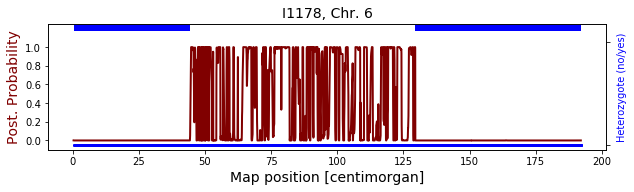


Test Passed!


0

In [15]:
test_plot_posterior()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


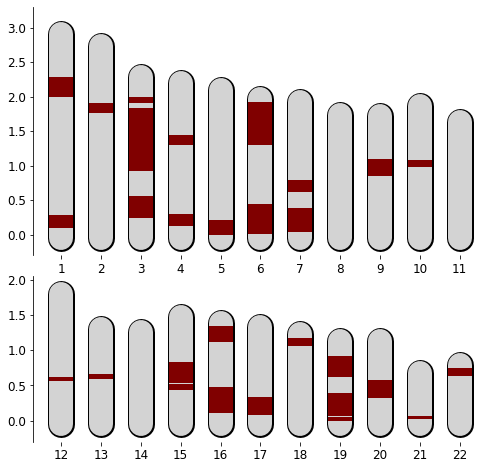


Test Passed!


0

In [16]:
test_plot_roh_individual()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


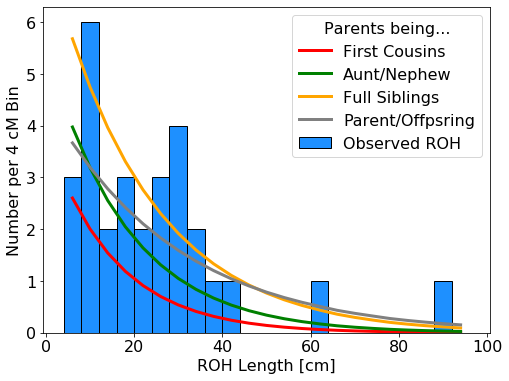


Test Passed!


0

In [17]:
test_plot_pde_individual()